## Comparing ICESat-2 Altimetry Elevations with DEM
### Example Notebook
This notebook compares elevations from ICESat-2 to those from a DEM.

#### Credits
* notebook by: [Jessica Scheick](https://github.com/JessicaS11) and [Shashank Bhushan](https://github.com/ShashankBice)


### Import packages, including icepyx

In [1]:
from icepyx import is2class as ipd
import os
import shutil
import h5py
import xarray as xr
# depedencies
import getpass
#from topolib.subsetDat import subsetBBox;
from topolib import IceSat2Data;
import glob
import rasterio
from topolib import gda_lib;
from topolib import dwnldArctic
import numpy as np
import geopandas as gpd
from multiprocessing import Pool
import contextily as ctx
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

/srv/conda/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/srv/conda/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


#### The Notebook was run on ICESat2 Hackweek 2019 pangeo image
##### For full functionality,
- Please install [icepyx](https://github.com/icesat2py/icepyx), [topolib](https://github.com/ICESAT-2HackWeek/topohack), [contextily](https://github.com/darribas/contextily) using `git clone xxxxx`, `pip install -e .` worfkflow
- Download [NASA ASP](https://github.com/NeoGeographyToolkit/StereoPipeline) tar ball and unzip, we execute the commands from the notebook, using the path to the untared bin folder for the given commands.

#### ICESat-2 product being explored : [ATL08](https://nsidc.org/data/atl08)
- Along track heights for canopy (land and vegitation) and  terrain
- Terrain heights provided are aggregated over every 100 m along track interval, output contains "h_te_best_fit: height from best fit algorithm for all photons in the range", median height and others. Here we use h_te_best_fit.
- See this preliminary introduction and quality assessment [paper](https://www.mdpi.com/2072-4292/11/14/1721) for more detail

### Create an ICESat-2 data object with the desired search parameters
See the ICESat-2 DAAC Data Access notebook for more details on downloading data from the NSIDC

In [2]:
region_a = ipd.Icesat2Data('ATL08', [-73.9, 10.7, -73.4, 11.1], ['2018-12-01','2019-09-01'], \
                          start_time='00:00:00', end_time='23:59:59')

### Finding and downloading data
In order to download any data from NSIDC, we must first authenticate ourselves using a valid Earthdata login. This will create a valid token to interface with the DAAC as well as start an active logged-in session to enable data download. The token is attached to the data object and stored, but the session must be passed to the download function. Then we can order the granules.

#### Log in to Earthdata

In [3]:
earthdata_uid = 'Shashank_17'
email = 'sbaglapl@uw.edu'
session=region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password:  ·········


In [4]:
#search for available granules
region_a.avail_granules()

{'Number of available granules': 20,
 'Average size of granules (MB)': 21.710584306709997,
 'Total size of all granules (MB)': 434.21168613419997}

In [5]:
region_a.reqparams['page_num'] = 1
region_a.reqparams

{'email': 'sbaglapl@uw.edu',
 'token': '2AB7BDFA-0033-995F-F571-9D4D369E00F7',
 'page_size': 10,
 'page_num': 1}

In [6]:
region_a.granule_info

{'Number of available granules': 20,
 'Average size of granules (MB)': 21.710584306709997,
 'Total size of all granules (MB)': 434.21168613419997}

In [7]:
#region_a.granules

#### Place the order

In [8]:
region_a.order_granules(session, subset=False)
#region_a.order_granules(session, verbose=True)

order ID:  5000000450378
Data request  1  is submitting...
Initial request status is  processing
Status is not complete. Trying again.
Retry request status is:  complete


In [9]:
#view a short list of order IDs
region_a.orderIDs

['5000000450378']

#### Download the order
Finally, we can download our order to a specified directory (which needs to have a full path but doesn't have to point to an existing directory) and the download status will be printed as the program runs. Additional information is again available by using the optional boolean keyword 'verbose'.

In [10]:
path = './download'
region_a.download_granules(session, path)

Beginning download of zipped output...
Data request 5000000450378 of  1  order(s) is complete.


#### Clean up the download folder by removing individual order folders:

In [11]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

In [12]:
datafolderOut = '/home/jovyan/icesat2/icepyx/doc/examples/download/download/'

In [13]:
# glob to list of files
ATL08_list = sorted(glob.glob(datafolderOut+'*.h5'))

### Examine content of 1 ATLO8 hdf file

In [14]:
filename = ATL08_list[5]
with h5py.File(filename, 'r') as f:
    # List all groups
    pairs=[1, 2, 3]
    beams=['l','r']
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]
#

Keys: <KeysViewHDF5 ['METADATA', 'ancillary_data', 'ds_metrics', 'ds_surf_type', 'gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r', 'orbit_info', 'quality_assessment']>


In [15]:
ATL08_list

['/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20181203060400_10020107_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20181207174958_10710101_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20190101044008_00570207_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20190105162606_01260201_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20190130031618_04990207_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20190203030801_05600207_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20190203150218_05680201_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20190304014401_10020207_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_20190308132958_10710201_002_01.h5',
 '/home/jovyan/icesat2/icepyx/doc/examples/download/download/ATL08_201904

In [16]:
# dict containing data entries to retrive
dataset_dict = {'land_segments':['delta_time','longitude','latitude','atl06_quality_summary','quality','terrain_flg'], 'land_segments/terrain':['h_te_best_fit']}

In [17]:
gda_lib.ATL08_to_dict(ATL08_list[0],dataset_dict)

[{'delta_time': array([29052308.61310044, 29052308.62720304, 29052308.64127883, ...,
         29052658.84409712, 29052661.04275581, 29052661.07092728]),
  'longitude': array([-72.51277 , -72.51286 , -72.512955, ..., -74.801735, -74.81583 ,
         -74.81602 ], dtype=float32),
  'latitude': array([22.62327   , 22.622368  , 22.621466  , ...,  0.20960146,
          0.06887273,  0.06706914], dtype=float32),
  'terrain_flg': array([0., 1., 0., ..., 1., 1., 1.]),
  'h_te_best_fit': array([-44.64416504, -44.51130676, -44.77741623, ..., 186.5337677 ,
         194.37980652, 193.97970581]),
  'pair': array([1., 1., 1., ..., 1., 1., 1.]),
  'beam': array([0., 0., 0., ..., 0., 0., 0.])},
 {'delta_time': array([29052308.93791027, 29052308.95191064, 29052308.96597921, ...,
         29052662.47302004, 29052662.48711049, 29052662.50114834]),
  'longitude': array([-72.51348 , -72.51357 , -72.513664, ..., -74.823616, -74.82371 ,
         -74.82379 ], dtype=float32),
  'latitude': array([ 2.2624245e+01,

In [18]:
## the data can be converted to geopandas dataframe, see ATL08_2_gdf function in topolib gda_lib
temp_gdf = gda_lib.ATL08_2_gdf(ATL08_list[0],dataset_dict)

In [19]:
temp_gdf.head()

,delta_time,longitude,latitude,terrain_flg,h_te_best_fit,pair,beam,p_b,geometry
0,2.905231e+07,-72.512772,22.623270,0.0,-44.644165,1.0,0.0,1.0_0.0,POINT (-72.51277160644531 22.62327003479004)
1,2.905231e+07,-72.512863,22.622368,1.0,-44.511307,1.0,0.0,1.0_0.0,POINT (-72.51286315917969 22.62236785888672)
2,2.905231e+07,-72.512955,22.621466,0.0,-44.777416,1.0,0.0,1.0_0.0,POINT (-72.51295471191406 22.6214656829834)
3,2.905231e+07,-72.513054,22.620565,0.0,-44.896725,1.0,0.0,1.0_0.0,POINT (-72.51305389404297 22.62056541442871)
4,2.905231e+07,-72.513145,22.619663,1.0,-44.382587,1.0,0.0,1.0_0.0,POINT (-72.51314544677734 22.61966323852539)


In [20]:
%matplotlib inline

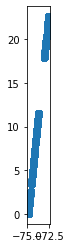

In [21]:
temp_gdf.plot()

In [22]:
len(temp_gdf)

46580

In [23]:
columbia_crs = {'init':'epsg:32618'}
plot_web = {'init':'epsg:3857'}

In [24]:
temp_gdf.keys()

Index(['delta_time', 'longitude', 'latitude', 'terrain_flg', 'h_te_best_fit',
       'pair', 'beam', 'p_b', 'geometry'],
      dtype='object')

### Convert the list of hdf5 files into more familiar Pandas Dataframe

In [25]:
gdf_list = [(gda_lib.ATL08_2_gdf(x,dataset_dict)) for x in ATL08_list]
gdf_columbia = gda_lib.concat_gdf(gdf_list)

[]

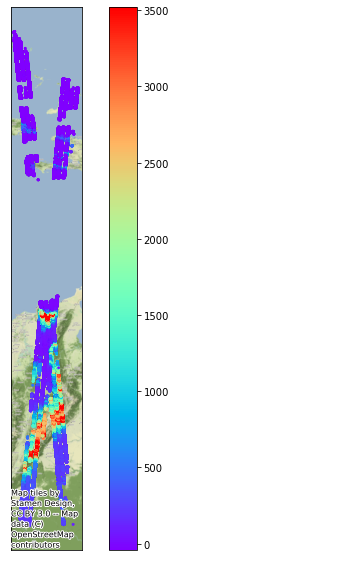

In [26]:
fig,ax = plt.subplots(figsize=(10,10))
temp_web = gdf_columbia.to_crs(plot_web)
clim = np.percentile(temp_web['h_te_best_fit'].values,(2,98))
temp_web.plot('h_te_best_fit',ax=ax,s=3,legend=True,cmap='rainbow',vmin=clim[0],vmax=clim[1])
ctx.add_basemap(ax=ax)
ax.set_xticks([])
ax.set_yticks([])

### We will use the TANDEM-X Global DEM for our comparison. The resolution of the globally avaialable product is 90 m, with *horizontal* and *vertical* accuracy better than 2 to 3 m.
- TANDEM-X DEM for the region was downloaded and preprocessed, filtered using scripts from the [tandemx](https://github.com/dshean/tandemx) repository

In [27]:
dem_file = '/home/jovyan/icesat2/TDM1_DEM_90m_columbia_DEM_masked_aea.tif'
hs_file = os.path.splitext(dem_file)[0]+'_hs.tif'
dem_ds = rasterio.open(dem_file)

In [28]:
! gdaldem hillshade $dem_file $hs_file

0...10...20...30...40...50...60...70...80...90...100 - done.


In [29]:
hs_ds = rasterio.open(hs_file)

In [30]:
def gdf_on_raster(gdf,ds,ax,hs_ds=None,cmap='inferno'):
    gdf = gdf.to_crs(ds.crs)
    xmin,ymin,xmax,ymax = ds.bounds
    ndv = gda_lib.get_ndv(ds)
    img = ds.read(1)
    img = np.ma.masked_less_equal(img,ndv)
    clim = np.nanpercentile(img,(2,98))
    if hs_ds:
        hs = hs_ds.read(1)
        ndv = gda_lib.get_ndv(hs_ds)
        hs = np.ma.masked_less_equal(hs,ndv)
        ax.imshow(hs,cmap='gray',extent=[xmin,xmax,ymin,ymax])
        im = ax.imshow(img,alpha=0.6,cmap=cmap,extent=[xmin,xmax,ymin,ymax])
        print(clim)
    else:
        im = ax.imshow(img,cmap=cmap,vmin=clim[0],vmax=clim[1],extent=[xmin,xmax,ymin,ymax])
    gdf.plot('p_b',ax=ax,s=1)
    plt.colorbar(im,ax=ax,extend='both',label='Elevation (m)')

In [31]:
xmin,ymin,xmax,ymax = dem_ds.bounds

In [32]:
## Filter points based on DEM extent

In [33]:
gdf_columbia['x_atc'] = gdf_columbia['delta_time']
gdf_columbia_dem_extent = gdf_columbia.to_crs(dem_ds.crs).cx[xmin:xmax,ymin:ymax]

[-32767.           2951.64549805]


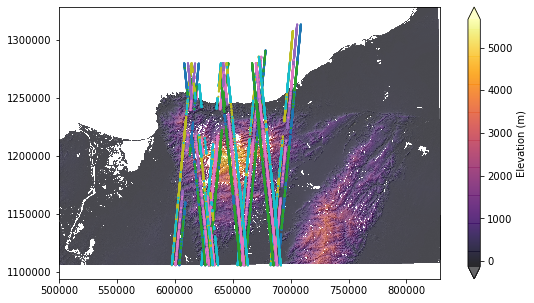

In [34]:
fig,ax = plt.subplots(figsize=(10,5))
gdf_on_raster(gdf_columbia_dem_extent,dem_ds,ax,hs_ds)

#### Sample elevations from DEM at ATLO8-locations using nearest neighbour algorithm 

In [35]:
del_time,elev = gda_lib.sample_near_nbor(dem_ds,gdf_columbia_dem_extent)

In [36]:
gdf_columbia_dem_extent['dem_z'] = elev

#### Plot elevation differences (ICESat-2 minus TANDEM-X) as a function of elevation


Text(0, 0.5, 'Elevation difference (m)')

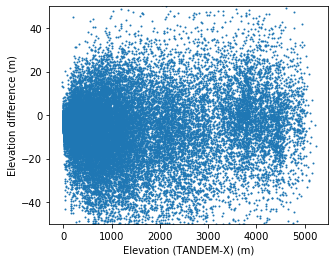

In [37]:
gdf_columbia_dem_extent['z_diff'] = gdf_columbia_dem_extent['h_te_best_fit'] - gdf_columbia_dem_extent['dem_z']
fig,ax = plt.subplots(figsize=(5,4))
# Sort elevation values
gdf_columbia_dem_extent.sort_values(by='dem_z',inplace=True)
gdf_columbia_dem_extent_filt = gdf_columbia_dem_extent[gdf_columbia_dem_extent['z_diff']<1000]
ax.scatter(gdf_columbia_dem_extent_filt.dem_z.values,gdf_columbia_dem_extent_filt.z_diff.values,s=1)
ax.set_ylim(-50,50)
ax.set_xlabel('Elevation (TANDEM-X) (m)')
ax.set_ylabel('Elevation difference (m)')

- The difference above might be noise or real signal (" the dates of ICESAT-2 footprints are between December to March 2018-2019, while TANDEM-X contains a mosaic of elevations between 2012-2014")
- It's hard to make out anything from the above plot, let's try a box plot

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0, 0.5, 'ICESat-2 minus ATLO8 (m)')

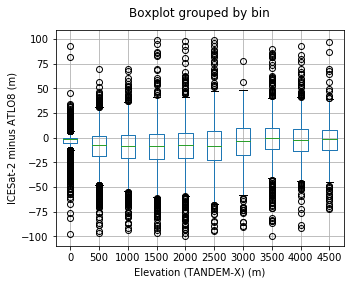

In [38]:
dem_bins = list(np.arange(0,5500,500))
# mask out differences larger than 100 m ?
filt_lim = (-100,100)
mask = (gdf_columbia_dem_extent['z_diff']<=100) & (gdf_columbia_dem_extent['z_diff']>=-100)
gdf_columbia_dem_extent_filt_box = gdf_columbia_dem_extent[mask]
gdf_columbia_dem_extent_filt_box['bin'] = pd.cut(gdf_columbia_dem_extent_filt_box['dem_z'],bins=dem_bins)
fig,ax = plt.subplots(figsize=(5,4))
gdf_columbia_dem_extent_filt_box.boxplot(column='z_diff',by='bin',ax=ax)
ax.set_xlabel('Elevation (TANDEM-X) (m)')
ax.set_xticklabels(dem_bins)
#ax.set_ylabel('Elevation difference (m)')
ax.set_title('')
ax.set_ylabel('ICESat-2 minus ATLO8 (m)')
#plt.tight_layout()

- The x labels in the plot are lower intervals of boxplots, we see that the median differences are close to zero for most elevation ranges with a maximum difference of -10 m. Also, we see a constant negative bias in all the elevation difference. This might be due to a bias present between the 2 sources. This bias maybe due to offset between the 2 datasets which might come down after coregistration.

# Going fancy, include only if you want to :)

#### Application of ICESat-2 as control for DEM co-registration ?
- Can use point cloud alignment techniques to align DEMs to points, for now as a starting point we can use the transformation matrix to inform on the horizontal and vertical offset between ICESat-2 tracks and DEMs
- We will be using a flavor of Iterative Closest Point alignment algorithm, implemented in [Ames Stereo Pipeline](https://github.com/NeoGeographyToolkit/StereoPipeline)

In [39]:
gdf_columbia_dem_extent.keys()

Index(['delta_time', 'longitude', 'latitude', 'terrain_flg', 'h_te_best_fit',
       'pair', 'beam', 'p_b', 'geometry', 'x_atc', 'dem_z', 'z_diff'],
      dtype='object')

In [40]:
### Save the geodataframe in the specified way as expected by Ames Stereo Pipline
icesat2_pc = '/home/jovyan/icesat2/icesat2_columbia_pc.csv' 
gdf_columbia_dem_extent[['latitude','longitude','h_te_best_fit']].to_csv(icesat2_pc,header=False,index=None)

In [41]:
gdf_columbia_dem_extent.head()

,delta_time,longitude,latitude,terrain_flg,h_te_best_fit,pair,beam,p_b,geometry,x_atc,dem_z,z_diff
831,2.905249e+07,-73.689125,11.268554,1.0,-3.830631,1.0,0.0,1.0_0.0,POINT (643085.4287785299 1245993.700456058),2.905249e+07,-32767.0,32763.169369
306,3.405362e+07,-73.087708,11.822446,0.0,-16.512878,1.0,0.0,1.0_0.0,POINT (708341.3413268254 1307632.688194632),3.405362e+07,-32767.0,32750.487122
307,3.405362e+07,-73.087807,11.821545,0.0,-16.170166,1.0,0.0,1.0_0.0,POINT (708331.213868225 1307532.908917141),3.405362e+07,-32767.0,32750.829834
308,3.405362e+07,-73.087898,11.820642,0.0,-16.313721,1.0,0.0,1.0_0.0,POINT (708321.9185105585 1307433.029837989),3.405362e+07,-32767.0,32750.686279
309,3.405362e+07,-73.087997,11.819741,0.0,-17.072906,1.0,0.0,1.0_0.0,POINT (708311.7908113913 1307333.250599968),3.405362e+07,-32767.0,32749.927094


In [42]:
### Save the geodataframe in the specified way as expected by Ames Stereo Pipline
icesat2_pc = '/home/jovyan/icesat2/icesat2_columbia_pc.csv'
pc_rename_dict = {'latitude':'lat','longitude':'lon','h_te_best_fit':'height_above_datum'}
gdf_columbia_dem_extent = gdf_columbia_dem_extent.rename(columns=pc_rename_dict)
#gdf_columbia_dem_extent['height_above_datum'] = gdf_columbia_dem_extent['h_te_best_fit']

gdf_columbia_dem_extent[['lon','lat','height_above_datum']].to_csv(icesat2_pc,header=True,index=None)

In [43]:
!exportPATH="/home/jovyan/icesat2/StereoPipeline/bin:$PATH"

In [44]:
! ls

download


In [45]:
align_fol = '/home/jovyan/icesat2/align/run'
#max-displacement is set to 10, given ICESat-2 reported operational accuracy
pc_align_opts="--csv-format '1:lon 2:lat 3:height_above_datum' --max-displacement 10 --save-transformed-source-points --alignment-method point-to-point --datum WGS84"
!/home/jovyan/icesat2/StereoPipeline/bin/pc_align $pc_align_opts $icesat2_pc $dem_file -o $align_fol

	--> Setting number of processing threads to: 4
Writing log info to: /home/jovyan/icesat2/align/run-log-pc_align-01-27-2133-2916.txt
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +proj=longlat +datum=WGS84 +no_defs
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-74.111, 9.99494) width: 1.0286 height: 1.8794)
Source box:    (Origin: (-75.0001, 9.99947) width: 3.00066 height: 2.00111)
Intersection reference box:  (Origin: (-74.111, 9.99947) width: 1.0286 height: 1.87486)
Intersection source    box:  (Origin: (-74.111, 9.99947) width: 1.0286 height: 1.87486)
Intersection of bounding boxes took 7.24496 [s]
Reading: /home/jovyan/icesat2/icesat2_columbia_pc.csv
Loaded points: 47714
Loading the reference point cloud took 0.155469 [s]
Reading: /home/jovyan/icesat2/TDM

In [51]:
##Lets rerun the analysis with the new DEM to see if the alignment improved anything or not
## Regrid the transformed pointcloud into DEM at 90 m posting
!/home/jovyan/icesat2/StereoPipeline/bin/point2dem --tr 90 --t_srs EPSG:32618 $align_fol-trans_source.tif

	--> Setting number of processing threads to: 4
Writing log info to: /home/jovyan/icesat2/align/run-trans_source-log-point2dem-01-27-2136-3157.txt
The point cloud files must have an equal number of channels which must be 4 or 6 to be able to remove outliers.
Statistics: [********************************************************] Complete!
QuadTree: [**********************************************************] Complete!
	-- Starting DEM rasterization --
	--> DEM spacing: 90 pt/px
	             or: 0.0111111 px/pt
Creating output file that is Vector2(3656,2479) px.
Writing: /home/jovyan/icesat2/align/run-trans_source-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels = 0.670479


In [47]:
gdf_columbia_dem_extent = gdf_columbia_dem_extent.loc[:,~gdf_columbia_dem_extent.columns.duplicated()]

In [48]:
gdf_columbia_dem_extent['height_above_datum'].values[5]

-16.466503143310547

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Text(0, 0.5, 'ICESat-2 minus ATLO8 after coregistration (m)')

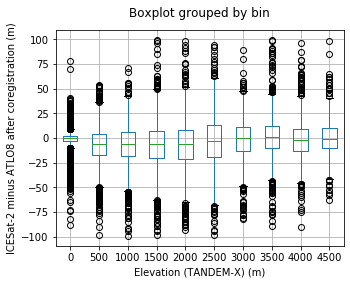

In [50]:
trans_dem_file = '/home/jovyan/icesat2/align/run-trans_source-DEM.tif'
trans_dem_ds = rasterio.open(trans_dem_file)
del_time,elev = gda_lib.sample_near_nbor(trans_dem_ds,gdf_columbia_dem_extent)
gdf_columbia_dem_extent['trans_dem_z'] = elev
dem_bins = list(np.arange(0,5500,500))
# mask out differences larger than 100 m ?
filt_lim = (-100,100)
gdf_columbia_dem_extent['trans_z_diff'] = gdf_columbia_dem_extent.height_above_datum - gdf_columbia_dem_extent.trans_dem_z

mask = (gdf_columbia_dem_extent['trans_z_diff']<=100) & (gdf_columbia_dem_extent['trans_z_diff']>=-100)
gdf_columbia_dem_extent_filt_box = gdf_columbia_dem_extent[mask]
gdf_columbia_dem_extent_filt_box['bin'] = pd.cut(gdf_columbia_dem_extent_filt_box['dem_z'],bins=dem_bins)
fig,ax = plt.subplots(figsize=(5,4))
gdf_columbia_dem_extent_filt_box.boxplot(column='trans_z_diff',by='bin',ax=ax)
ax.set_xlabel('Elevation (TANDEM-X) (m)')
ax.set_xticklabels(dem_bins)
ax.set_title('')
ax.set_ylabel('ICESat-2 minus ATLO8 after coregistration (m)')



- We see that after coregistration, the bias reduces to an extent. Note that this is a very preliminary analysis, results will be better after filtering the ATL08 points based on quality metrics and finding truly static surfaces (snow free during acquisiton time of ICESat-2 points)